In [ ]:
 #networkx para teoría de grafos, matplot para gráficar y random para generar números aleatorios
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp 
from scipy import stats as st
import math 
from scipy.optimize import fsolve

# GENERADOR DE SECUENCIAS DE ENTEROS POSITIVOS CON UNA DISTRIBUCIÓN DE GRADO DADA 

In [ ]:
def Degree_Sec_Generator(Probabilidad_Acumulada,longitud_Secuencia):
  """
  (Vector Probabilidada Acumulada, Longitud Secuencia) -------> Secuencia de enteros con la distribución del vector
  """
  Degree_Sequence = []
  sum = 0
  for i in range(longitud_Secuencia):
    k = st.uniform.rvs(scale = Probabilidad_Acumulada[len(Probabilidad_Acumulada)-1]) #Se generan números aleatoriamente entre 0 y 1
    for j in range(len(Probabilidad_Acumulada)):
      if k <= Probabilidad_Acumulada[j]: # Asocia un entero positivo a cada número entre 0-1
        Degree_Sequence.append(j) #construye el vector con los enteros positivos asociados a los números entre 0-1
        break
  return Degree_Sequence

# LA SIGUIENTE FUNCIÓN DADO UN GRAFO G CALCULA LA ENTROPÍA DE SHANNON PARA LOS PARAMETROS NODALES: GRADO, CENTRALIDAD DE AUTOVECTOR, INTERMEDIACIÓN Y CENTRALIDAD DE CERCANÍA 

In [ ]:
# Está función calcula la entropía de distintas distribuciones de medidas para un grafo
def graph_entropys(G):
  """
  Recibe un grafo y entrega números
  (Graph) -----> Degree_Entropy, Eigenvector_Entropy, Betweenness_Entropy, Closeness_Entropy
  """
  EIGENVECTOR = []
  DEGREE = []
  BETWEENNESS = []
  CLOSENESS = []
  load = []
  #las siguientes 4 lineas producen 4 diccionarios con los nodos y sus centralidades correspondientes
  eigenvector = nx.eigenvector_centrality(G)
  degree = nx.degree(G) 
  betweenness = nx.betweenness_centrality(G) 
  closeness = nx.closeness_centrality(G) 
  load = nx.load
  for i in range(len(eigenvector)): #este for desempaqueta los diccionarios, para coger solo las centralidades en listas
    EIGENVECTOR.append(eigenvector[i])
    DEGREE.append(degree[i])
    BETWEENNESS.append(betweenness[i])
    CLOSENESS.append(closeness[i])
  # aca se usa el modulo stats de scipy para calcular las entropias
  Closeness_Entropy = st.entropy(CLOSENESS)
  Degree_Entropy = st.entropy(DEGREE)
  Eigenvector_Entropy = st.entropy(EIGENVECTOR)
  Betweenness_Entropy = st.entropy(BETWEENNESS)
  return Degree_Entropy, Eigenvector_Entropy, Betweenness_Entropy, Closeness_Entropy


# LOS SIGUIENTES ALGORITMOS SON PARA REALIZAR FALLAS EN CASCADAS EN UN GRAFO

In [ ]:
# Esta función ataca nodos aleatoriamente y genera fallos en cascada en base a la medida load, la cual es una variación de la intermediacion
def aleatory_cascade_failure(G,Initial_Capacity,Resiliencia,Number_Attacks):
  """
  (Graph,float,float,int) -------> (G,Vector con los daños, vector con el número de ataques)
  """
  load1 = nx.load_centrality(G)
  LOAD1 = list(load1)
  C = []
  for i in range(len(LOAD1)):
    q = (1+Initial_Capacity)*LOAD1[i]
    C.append(q)
  DAMAGE = []
  ATTACK = []
  for i in range(Number_Attacks):
    remove_aleatory(G,1)
    DELETE_NODES = []
    LOAD = []
    load = nx.load_centrality(G)
    for j in G.nodes():
      val = Resiliencia*C[j]
      LOAD.append(load[j])
      if load[j] > val:
        DELETE_NODES.append(j)
      else:
        if load[j] > C[j]:
          k = st.uniform.rvs()
          P = (1/(Resiliencia-1))*(load[j]/C[j] -1)
          if k <= P:
            DELETE_NODES.append(j)
    G.remove_nodes_from(DELETE_NODES)
    NodosBC = len(max(nx.connected_components(G), key=len))
    DAMAGE.append(NodosBC/len(LOAD1))
    ATTACK.append(i)
  return G,ATTACK,DAMAGE

In [ ]:

#Estas funciones remueven N nodos del grafo ingresado
def remove_hubs_load(G,nodos_removidos):
  for i in range(nodos_removidos):
    keys = list(nx.load_centrality(G).keys())
    values = list(nx.load_centrality(G).values())
    maxval = max(values)
    casilla_nodo = values.index(maxval)
    G.remove_node(keys[casilla_nodo])
  return G

def remove_aleatory(G,nodos_removidos):
  for i in range(nodos_removidos):
    remove_node = np.random.randint(0,G.number_of_nodes())
    if (remove_node in G) == True:
      G.remove_node(remove_node)
  return(G)

In [ ]:
# Esta función ataca nodos hubs en base a la medida load y genera fallos en cascada en base a la misma medida
def hub_cascade_failure(G,Initial_Capacity,Resiliencia,Number_Attacks):
  """
  (Graph,float,float,int) -------> (G)
  """
  load1 = nx.load_centrality(G)
  LOAD1 = list(load1)
  C = []
  for i in range(len(LOAD1)):
    q = (1+Initial_Capacity)*LOAD1[i]
    C.append(q)
  DAMAGE = []
  ATTACK = []
  for i in range(Number_Attacks):
    remove_hubs_load(G,1)
    DELETE_NODES = []
    LOAD = []
    load = nx.load_centrality(G)
    for j in G.nodes():
      val = Resiliencia*C[j]
      LOAD.append(load[j])
      if load[j] > val:
        DELETE_NODES.append(j)
      else:
        if load[j] > C[j]:
          k = st.uniform.rvs()
          P = (1/(Resiliencia-1))*(load[j]/C[j] -1)
          if k <= P:
            DELETE_NODES.append(j)
    G.remove_nodes_from(DELETE_NODES)
    NodosBC = len(max(nx.connected_components(G), key=len))
    DAMAGE.append(NodosBC/len(LOAD1))
    ATTACK.append(i)
  return G,ATTACK,DAMAGE

In [ ]:
#este algoritmo es para muestrear secuencias de grado y calcular la secuencia de grado promedio
def Deg_Sec_Prom(Muestreo_seq,Number_nodes,probability_distribution):
  Deg = []
  for i in range(Muestreo_seq):
    Deg.append([])
    for k in range(10000):
      Degree_Sequence = Degree_Sec_Generator(probability_distribution,Number_nodes)
      if nx.is_valid_degree_sequence_havel_hakimi(Degree_Sequence) == True:
        if nx.is_connected(nx.havel_hakimi_graph(Degree_Sequence)) == True:
          Degree_Sequence.sort()
          for l in range(len(Degree_Sequence)):
            Deg[i].append(Degree_Sequence[l])
          break

  Degree_sequence_prom = []
  for i in range(Number_nodes - 10):
    sum = 0
    for j in range(Muestreo_seq):
      sum = sum + Deg[j][i]
    Degree_sequence_prom.append(sum/Muestreo_seq)
  return Degree_sequence_prom


In [ ]:
# este algoritmo construye la matriz de adyacencia promedio a partir de los multiplicadores de lagrange para un ensamble canonico
def canonical_matrix(Multiplicadores_Lagrange):
  Adyacencia_promedio = []
  for i in range(len(Multiplicadores_Lagrange)):
    Adyacencia_promedio.append([])
    for j in range(len(Multiplicadores_Lagrange)):
      Adyacencia_promedio[i].append(1/(1 + math.exp((Multiplicadores_Lagrange[i] + Multiplicadores_Lagrange[j]))))
  for i in range(len(Multiplicadores_Lagrange)):
    Adyacencia_promedio[i][i] = 0
  return Adyacencia_promedio

In [ ]:
#este algoritmo muestrea el ensamble de redes por medio del algoritmo de máxima entropía, calcula sus matrices de adyacencia
#las promedia y te entrega la secuencia de grado promedio
def muestra_ensamble_maxent(muestra,number_of_nodes,P):
  connectivity_matrix = np.zeros((muestra, number_of_nodes, number_of_nodes))
  for l in range(muestra):
    Number_nodes = number_of_nodes + 10
    for k in range(10000):
      Degree_Sequence = Degree_Sec_Generator(P,Number_nodes)
      if nx.is_valid_degree_sequence_havel_hakimi(Degree_Sequence) == True:
        if nx.is_connected(nx.havel_hakimi_graph(Degree_Sequence)) == True:
          Degree_Sequence.sort()
          G = nx.havel_hakimi_graph(Degree_Sequence)
          break
    nx.double_edge_swap(G,nswap=150,max_tries=150000)
    adjacency = nx.adjacency_matrix(G)
    for i in range(number_of_nodes):
      for j in range(number_of_nodes):
        connectivity_matrix[l][i][j] = adjacency[(i,j)]

  adjacencia_insilico = np.zeros((number_of_nodes,number_of_nodes))

  for i in range(number_of_nodes):
    for j in range(number_of_nodes):
      adjprom = 0
      for l in range(muestra):
        adjprom = adjprom + connectivity_matrix[l][i][j]
      adjprom = adjprom/muestra
      adjacencia_insilico[i][j] = adjprom
  return Degree_sequence_prom, adjacencia_insilico

In [ ]:
# este programa te calcula los multiplicadores de lagrange dada una secuencia de grado, para el ensamble canonico.
def multp_lagrange_canonico(lagrange_multiplicators, degre_seq):
  def lagrange_eq(lagrange_multiplicators, degre_seq):
    n = len(lagrange_multiplicators)
    matrix = np.zeros((n,n))
    for i in range(n):
      for j in range(n):
        matrix[i][j] = 1/(math.exp(lagrange_multiplicators[i] + lagrange_multiplicators[j]) + 1)
      matrix[i][i] = 0
    sums = []
    for i in range(n):
      sum = 0
      for j in range(n):
        sum = sum + matrix[i][j]
      sums.append(sum)
    resultado = np.zeros(n)
    for i in range(n):
      resultado[i] = sums[i] - degre_seq[i] 
    return resultado

  x0 = np.zeros(len(lagrange_multiplicators))
  print(x0)

  multiplicadores = fsolve(lagrange,x0)
  return multiplicadores

In [ ]:
def cumm_probabilities(n, dx, distribution = st.pareto.cdf):
  dx = m/n
  x = []
  P = []
  for i in range(n):
    equis = 1 + dx*i
    x.append(equis)
    pes = st.pareto.cdf(x[i],2) 
    P.append(pes)
  return P, x

In [ ]:
n = 95
m = 20
P, x = cumm_probabilities(n,m)
print(P)
print(len(P))
print(x)

[0.0, 0.3175803402646503, 0.50480109739369, 0.6243496357960457, 0.7053061224489796, 0.7626561472715319, 0.8047593293672255, 0.8365776369397918, 0.8612072279892349, 0.8806611570247933, 0.8962941683424304, 0.90904509952129, 0.919581198485186, 0.9283872247569926, 0.9358222222222222, 0.9421567056561448, 0.9475976193932356, 0.9523054564671687, 0.9564062311315058, 0.96, 0.9631670237730844, 0.9659722876802714, 0.9684688619093371, 0.9707004301598896, 0.972703213610586, 0.9745074500388391, 0.9761385418732236, 0.9776179552359104, 0.9789639298409184, 0.9801920438957475, 0.9813156668909476, 0.9823463250036677, 0.9832939978712574, 0.9841673610806544, 0.9849739854318418, 0.9857205015624382, 0.9864127366479732, 0.9870558284628348, 0.9876543209876543, 0.9882122448979592, 0.9887331856059424, 0.989220341007495, 0.9896765706768852, 0.990104437926592, 0.9905062458908612, 0.9908840685841267, 0.9912397777184596, 0.9915750659291932, 0.9918914669481818, 0.992190373174689, 0.9924730510206209, 0.992740654346558

In [ ]:
# generamos una secuencia de grado muestreando aleatoriamente con distribución uniforme una muestra multinomial de la distribución de Pareto
# Luego validamos que la secuencia de grado sea apta para generar un grafo simple y conectado de la misma
Number_nodes = 150
for k in range(10000):
  Degree_Sequence = Degree_Sec_Generator(P,Number_nodes) #Degree sec generator fue definida arriba
  if nx.is_valid_degree_sequence_havel_hakimi(Degree_Sequence) == True:
    if nx.is_connected(nx.havel_hakimi_graph(Degree_Sequence)) == True:
      Degree_Sequence.sort()
      G = nx.havel_hakimi_graph(Degree_Sequence)
      break
print(Degree_Sequence)

[1, 1, 2, 5, 9, 3, 1, 2, 5, 2, 14, 1, 3, 2, 1, 1, 1, 1, 3, 2, 7, 2, 10, 1, 1, 4, 1, 3, 3, 3, 7, 4, 2, 2, 1, 3, 10, 2, 23, 4, 3, 2, 7, 1, 6, 3, 4, 1, 2, 2, 5, 7, 1, 2, 1, 14, 3, 30, 1, 1, 5, 8, 4, 5, 3, 8, 1, 3, 1, 1, 2, 13, 7, 1, 1, 1, 54, 1, 1, 1, 1, 1, 1, 3, 11, 7, 1, 20, 1, 3, 4, 1, 2, 3, 16, 1, 2, 7, 4, 1, 5, 1, 9, 4, 6, 1, 1, 4, 1, 7, 4, 3, 8, 1, 1, 14, 2, 1, 1, 4, 1, 5, 5, 5, 17, 4, 4, 3, 1, 1, 1, 3, 1, 6, 1, 2, 1, 2, 3, 2, 1, 6, 9, 3, 3, 11, 1, 1, 1, 2]


349
100


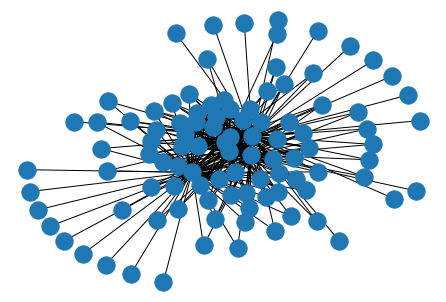

In [ ]:
sum = 0
print(nx.number_of_edges(G))
print(nx.number_of_nodes(G))
nx.draw(G)


In [ ]:
swip = []
ENTBET = []
ENTEIG = []
Numswips = 300
for i in range(Numswips):
  swip.append(i)
  Degree_Entropy, Eigenvector_Entropy, Betweenness_Entropy, Closeness_Entropy = graph_entropys(G)
  ENTBET.append(Betweenness_Entropy)
  ENTEIG.append(Eigenvector_Entropy)
  nx.double_edge_swap(G,nswap=1,max_tries=10000)

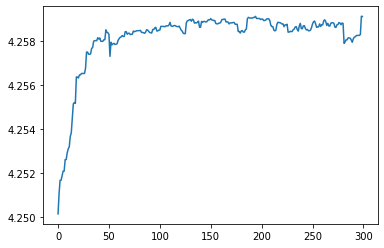

In [ ]:
plt.plot(swip,ENTEIG)
grafo = G

In [ ]:
G, ATTACK, DAMAGE = hub_cascade_failure(G,1,1.1,50)
#G, ATTACK, DAMAGE = aleatory_cascade_failure(G,1,1.1,100)

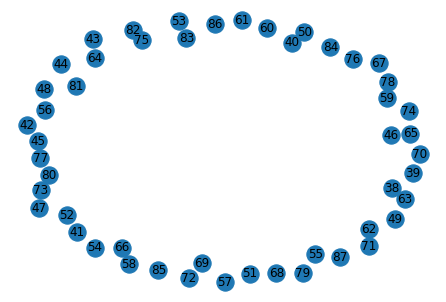

In [ ]:
nx.draw_spring(G,with_labels = True)

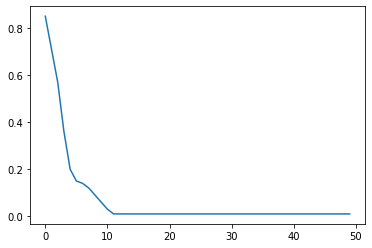

In [ ]:
plt.plot(ATTACK,DAMAGE)

In [ ]:
M = nx.barabasi_albert_graph(120,3)
print(nx.degree(M))
print(nx.number_of_edges(M))
M, ATTACK, DAMAGE = hub_cascade_failure(M,1,1.1,100)

[(0, 5), (1, 6), (2, 26), (3, 28), (4, 22), (5, 18), (6, 21), (7, 6), (8, 31), (9, 11), (10, 16), (11, 6), (12, 21), (13, 24), (14, 16), (15, 12), (16, 7), (17, 3), (18, 8), (19, 3), (20, 6), (21, 5), (22, 4), (23, 4), (24, 6), (25, 6), (26, 9), (27, 6), (28, 7), (29, 4), (30, 7), (31, 3), (32, 4), (33, 9), (34, 8), (35, 3), (36, 3), (37, 5), (38, 3), (39, 5), (40, 4), (41, 3), (42, 4), (43, 7), (44, 6), (45, 6), (46, 6), (47, 5), (48, 10), (49, 5), (50, 5), (51, 5), (52, 5), (53, 3), (54, 7), (55, 4), (56, 3), (57, 3), (58, 6), (59, 3), (60, 4), (61, 5), (62, 4), (63, 3), (64, 3), (65, 4), (66, 3), (67, 4), (68, 5), (69, 7), (70, 3), (71, 4), (72, 3), (73, 5), (74, 3), (75, 3), (76, 4), (77, 5), (78, 3), (79, 3), (80, 4), (81, 3), (82, 4), (83, 5), (84, 3), (85, 3), (86, 3), (87, 3), (88, 3), (89, 4), (90, 3), (91, 3), (92, 3), (93, 4), (94, 3), (95, 3), (96, 3), (97, 3), (98, 3), (99, 3), (100, 3), (101, 3), (102, 4), (103, 3), (104, 3), (105, 3), (106, 3), (107, 3), (108, 3), (109, 

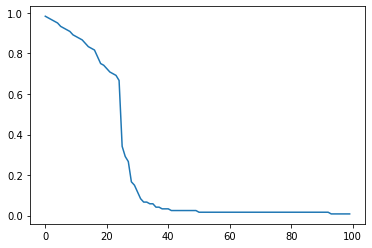

In [ ]:
plt.plot(ATTACK,DAMAGE)


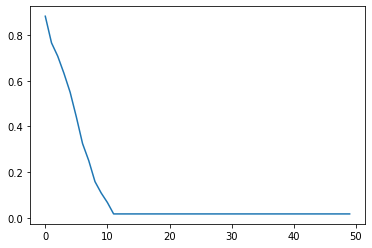

In [ ]:
G, ATTACK, DAMAGE = hub_cascade_failure(G,1,1.1,50)
plt.plot(ATTACK,DAMAGE)

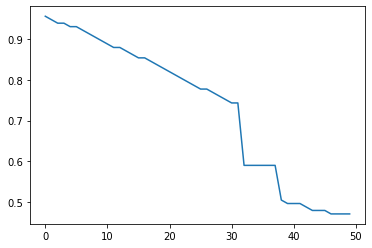

In [ ]:
G, ATTACK, DAMAGE = aleatory_cascade_failure(G,1,1.1,50)
plt.plot(ATTACK,DAMAGE)

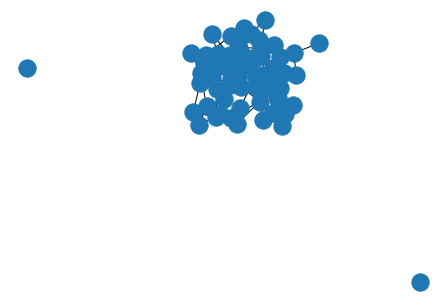

In [ ]:

G, ATTACK, DAMAGE = aleatory_cascade_failure(G,1,1.1,50)
nx.draw(G)

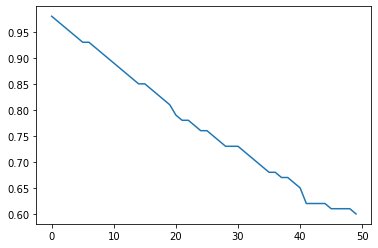

In [ ]:
G = nx.barabasi_albert_graph()
plt.plot(ATTACK,DAMAGE)